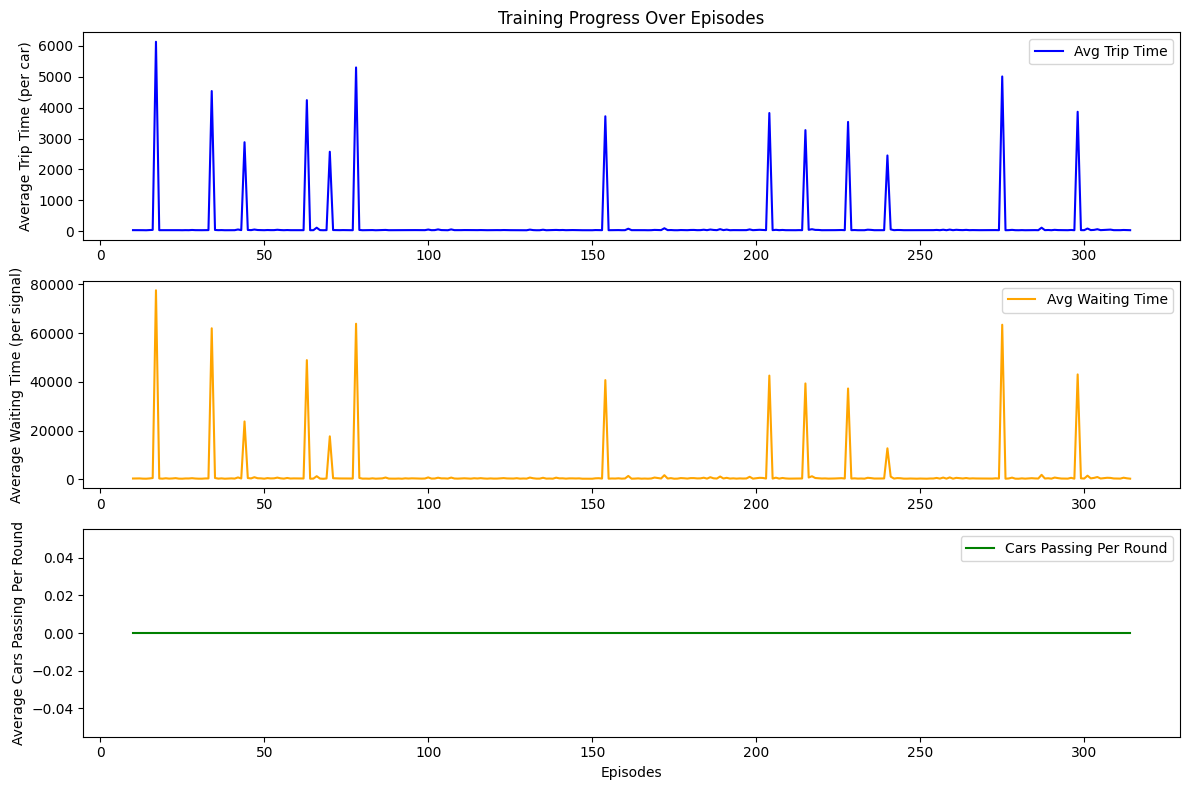

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

# Define the path to the files
file_path = "ql_3x3grid_train_results_preAlgorithm*.csv"  # Adjust this to your path

# Get a list of all files
files = glob.glob(file_path)

# Function to extract episode number from the filename
def extract_episode_number(filename):
    match = re.search(r'_ep(\d+)\.csv', filename)
    if match:
        return int(match.group(1))
    return -1  # Return -1 if no match is found, to handle unexpected filenames

# Sort files by episode number
files_sorted = sorted(files, key=extract_episode_number)

# Initialize lists to hold aggregated data
episodes = []
avg_trip_times = []
avg_waiting_times = []
cars_passing_per_round = []

# Loop through all the files to extract the key metrics for visualization
for file in files_sorted:
    df = pd.read_csv(file)
    
    # Check if the file is not empty and has valid data
    if not df.empty and 'step' in df.columns:
        # Episode number
        episode_number = extract_episode_number(file)
        episodes.append(episode_number)
        
        # Average trip time: total waiting time divided by number of cars
        total_waiting_time = df['system_total_waiting_time'].sum()
        total_stopped_cars = df['agents_total_stopped'].sum()
        
        if total_stopped_cars > 0:
            avg_trip_time = total_waiting_time / total_stopped_cars
        else:
            avg_trip_time = 0
        
        avg_trip_times.append(avg_trip_time)
        
        # Average waiting time for all signals
        avg_waiting_time = df[[f'{i}_accumulated_waiting_time' for i in range(9)]].mean().mean()
        avg_waiting_times.append(avg_waiting_time)
        
        # Average number of cars passing per round: cars that are no longer stopped at signals
        cars_stopped_at_step = df[[f'{i}_stopped' for i in range(9)]].sum(axis=1)
        total_cars_in_system = df['agents_total_stopped']  # Total cars in the system
        cars_passing = total_cars_in_system - cars_stopped_at_step  # Cars that passed
        avg_cars_passing = cars_passing.mean()  # Average cars passing per step
        cars_passing_per_round.append(avg_cars_passing)

# Convert to DataFrame for easier manipulation
df_metrics = pd.DataFrame({
    'Episode': episodes,
    'Avg Trip Time': avg_trip_times,
    'Avg Waiting Time': avg_waiting_times,
    'Cars Passing Per Round': cars_passing_per_round
})

# Create plots to visualize the training progress
plt.figure(figsize=(12, 8))

# Plot average trip time over episodes
plt.subplot(3, 1, 1)
plt.plot(df_metrics['Episode'], df_metrics['Avg Trip Time'], label='Avg Trip Time', color='blue')
plt.title('Training Progress Over Episodes')
plt.ylabel('Average Trip Time (per car)')
plt.legend()

# Plot average waiting time over episodes
plt.subplot(3, 1, 2)
plt.plot(df_metrics['Episode'], df_metrics['Avg Waiting Time'], label='Avg Waiting Time', color='orange')
plt.ylabel('Average Waiting Time (per signal)')
plt.legend()

# Plot cars passing per round over episodes
plt.subplot(3, 1, 3)
plt.plot(df_metrics['Episode'], df_metrics['Cars Passing Per Round'], label='Cars Passing Per Round', color='green')
plt.xlabel('Episodes')
plt.ylabel('Average Cars Passing Per Round')
plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


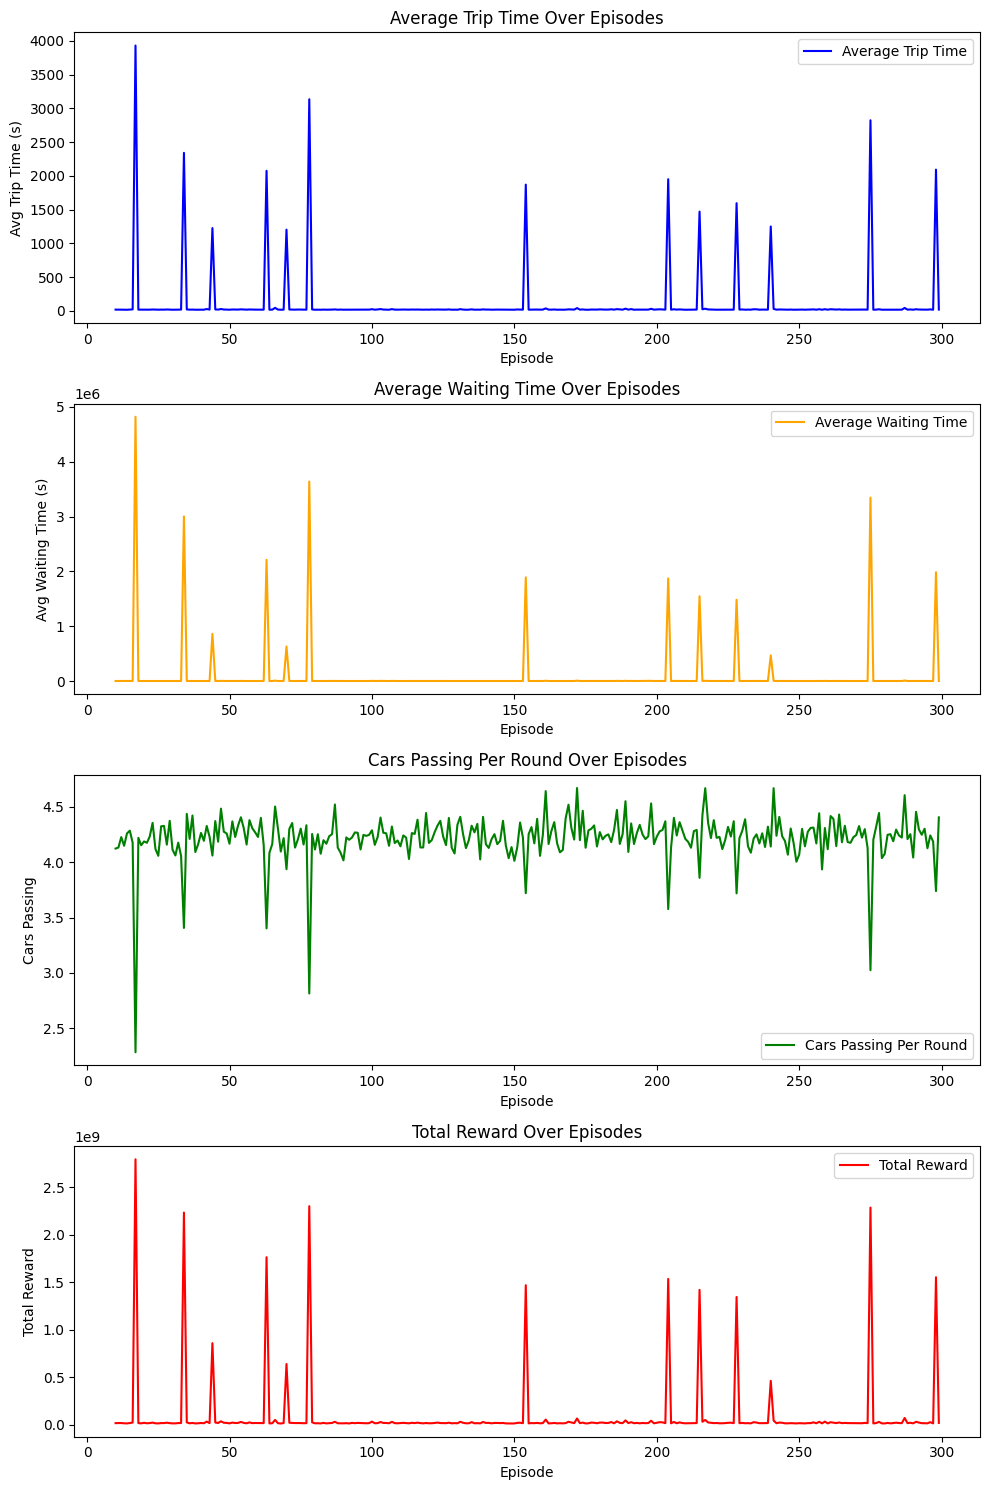

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from multiple CSV files (assuming all your CSVs have a similar format)
# You can modify the file paths as necessary.
episodes = list(range(10, 300))  # Assuming you have 300 episodes
dataframes = []
for ep in episodes:
    filepath = f'ql_3x3grid_train_results_preAlgorithm.csv_conn0_ep{ep}.csv'
    try:
        df = pd.read_csv(filepath)
        dataframes.append(df)
    except FileNotFoundError:
        print(f"File {filepath} not found.")
        continue

# Calculate the necessary metrics
avg_trip_times = []
avg_waiting_times = []
cars_passing_per_round = []
total_rewards = []  # Assuming you have a reward calculation (if not, you can skip this part)

for df in dataframes:
    # Average Trip Time (assuming it's recorded per step)
    avg_trip_time = df['system_mean_waiting_time'].mean()  # Modify if trip time is calculated differently
    avg_trip_times.append(avg_trip_time)
    
    # Average Waiting Time at Signals
    avg_waiting_time = df['system_total_waiting_time'].mean()
    avg_waiting_times.append(avg_waiting_time)
    
    # Cars Passing Per Round (cars that stop go down)
    # Count how many cars pass through by comparing stopped vehicles between rounds
    total_stopped = df['system_total_stopped']
    cars_passing = total_stopped.diff().abs().sum() / len(total_stopped)  # Total cars moving per round
    cars_passing_per_round.append(cars_passing)
    
    # Total Reward (if reward is present, this is optional)
    # Assuming some form of total reward is stored or computed in the data
    total_reward = df['agents_total_accumulated_waiting_time'].sum()  # Modify this based on your reward
    total_rewards.append(total_reward)

# Plotting the results

fig, axs = plt.subplots(4, 1, figsize=(10, 15))

# Plot Average Trip Time
axs[0].plot(episodes, avg_trip_times, label='Average Trip Time', color='blue')
axs[0].set_title('Average Trip Time Over Episodes')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Avg Trip Time (s)')
axs[0].legend()

# Plot Average Waiting Time at Signals
axs[1].plot(episodes, avg_waiting_times, label='Average Waiting Time', color='orange')
axs[1].set_title('Average Waiting Time Over Episodes')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Avg Waiting Time (s)')
axs[1].legend()

# Plot Cars Passing Per Round
axs[2].plot(episodes, cars_passing_per_round, label='Cars Passing Per Round', color='green')
axs[2].set_title('Cars Passing Per Round Over Episodes')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Cars Passing')
axs[2].legend()

# Plot Total Reward (optional)
if total_rewards:
    axs[3].plot(episodes, total_rewards, label='Total Reward', color='red')
    axs[3].set_title('Total Reward Over Episodes')
    axs[3].set_xlabel('Episode')
    axs[3].set_ylabel('Total Reward')
    axs[3].legend()

plt.tight_layout()
plt.show()


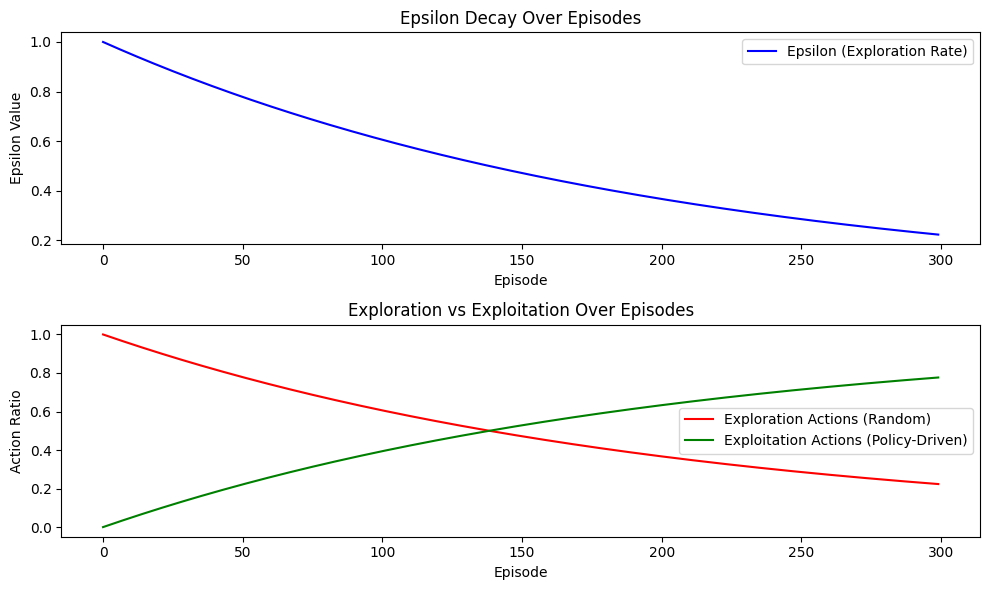

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have access to your epsilon value over episodes and actions taken
# Let's simulate this with some example data
# Replace with your actual epsilon decay logic and tracking
episodes = 300  # Number of episodes (replace with actual number)
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995  # Decay factor per episode (replace with your value)

epsilons = []
exploration_actions = []
exploitation_actions = []

epsilon = epsilon_start
for episode in range(episodes):
    # Track epsilon decay over episodes
    epsilons.append(epsilon)
    
    # Assuming exploration happens based on epsilon, simulate actions:
    random_action_ratio = epsilon  # Percentage of random actions (exploration)
    policy_action_ratio = 1 - epsilon  # Percentage of policy-driven actions (exploitation)
    
    exploration_actions.append(random_action_ratio)
    exploitation_actions.append(policy_action_ratio)
    
    # Decay epsilon (adjust as per your decay formula)
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

# Plotting epsilon decay
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(epsilons, label="Epsilon (Exploration Rate)", color="blue")
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon Value")
plt.legend()

# Plotting exploration vs exploitation actions
plt.subplot(2, 1, 2)
plt.plot(exploration_actions, label="Exploration Actions (Random)", color="red")
plt.plot(exploitation_actions, label="Exploitation Actions (Policy-Driven)", color="green")
plt.title("Exploration vs Exploitation Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Action Ratio")
plt.legend()

plt.tight_layout()
plt.show()